# Lunch & Learn 2: Practical Signal Processing @ Simbex
Goal is to provide some basic practical skills typically used at simbex and to ensure we'll all approaching this from the same base knowledge so we don't make inadvertent mistakes. This is a very pragmatic approach with some examples to reinforce the concepts.

## Prerequisites 
You need to make sure you have the following to run this jupyter notebook:

1. Install [anaconda](https://www.anaconda.com/products/individual)
2. Install virtual environment using SignalProcessing.yml - this installs the right version of python along with libraries
  * In the command prompt, run 'conda env create --file SignalProcessing.yml'

## Learning Topics
* Analog to digital conversion and sample rate
  * Effects of Aliasing signals
  * Bit Resolution
* Basics of filtering
  * Bode plots - phase and magnitude analysis
  * the 3db point
  * FIR and IIR filters - speed, attenuation, phase
  * different filters for different needs



In [1]:
## import libraries needed for this example
import numpy as np  # for numpy functions and arrays
# from tqdm import tqdm  # progress bar
# import pandas as pd  # dataframe in case we need it
from scipy import signal  # signal processing functions
# from ipywidgets import *  # interactive widgets
import matplotlib.pyplot as plt  # plotting
from typing import List # type definitions
from collections import defaultdict 
%matplotlib inline

## Internal support functions

In [2]:
def CreateSignal(amp: float, freq: float, time: np.ndarray) -> np.ndarray:
    """ Create a waveform based on amplitude and frequency"""
    newSig = amp * np.sin(2.0 * np.pi * freq * time)
    return newSig



## Analog to Digital Sampling (A/D)
An analog signal is defined as a *time varying* signal that has *infinite* time and *infinite* magnitude resolution. These signals are ubiquitous, music from a violin, temperature change in a thermometer, channel data from the cable company. All are time varying signals that carry information. With infinite resolution and time scale, we don't have the means or capacity to analyze these data the digital domain using a computer and need to convert (digitize) these signals into quantifiable discrete points. An A/D conversion process, basically digitizes an analog signal in both time (sampling frequency) and resolution/magnitude (bit resolution). 

We'll simulate a time varying signal at a really high temporal and magnitude resolution to represent a true analog signal and we'll look at the effects of sampling this frequency at different frequency rates.


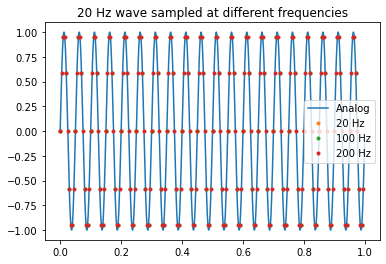

In [3]:
# create an "analog" signal
amp: float = 1.0  # signal amplitude in A.U.
freq: float = 20  # signal frequency in Hz
subSampleRates: List = [20, 100, 200]  # Hz different subsampling frequencies
sampleRate: float = 1000.0  # really high sample rate in Hz
time: np.ndarray = np.arange(0, 1.0, 1.0/sampleRate)  # create a time series with really small delta t in secs
analogSignal = CreateSignal(amp, freq, time)

# simulate time digitization
digitalSignal = defaultdict(dict)  # use a dict to store the data
for i in subSampleRates:
    digitalSignal[i]['interval'] = int(sampleRate/i) # skip n data points to subsample
    digitalSignal[i]['data'] = analogSignal[::digitalSignal[i]['interval']]  # save the data

# plot this signal
plt.plot(time, analogSignal, label='Analog') # this should plot the number of sin waves defined by freq above
for i in digitalSignal:
    sig = digitalSignal[i]
    plt.plot(time[::sig['interval']], sig['data'], '.', label=f'{i} Hz')
plt.title(f"{freq} Hz wave sampled at different frequencies")
plt.legend()

In the figure above, we have taken an analog signal and sampled it at different rates. If you look carefully and zoom in, you can see that different sampling rates have some interesting effects:

1. Amount of data is recorded is significantly less with little loss of signal fidelity
2. frequency of the signal is captured at both 200 and 100 Hz subsampling (Nyquist Theorem: sample rate is at least > 2x highest frequency of interest or freq in the data)
3. mangitude is **NOT** captured correctly at any subsampling
4. 20 Hz subsamplilng misses the signal characteristics entirely even if we follow nyquist theorem

Lets take a slightly different look at this to see these differences better. At 20 Hz, we're only collecting 20 samples per second. At a frequency of 20 Hz, we completely miss *any* of the freatures in the data. At 100 Hz sample rate, we only have 5 samples per cycle, but this is sufficient for capturing the frequency of interest, but the sample time for the peak isn't quite at the peak which we miss. Adhereing to nyquist theorem allows us to recreate the freqency of the signal, but the temporal features of the data could still be missed.


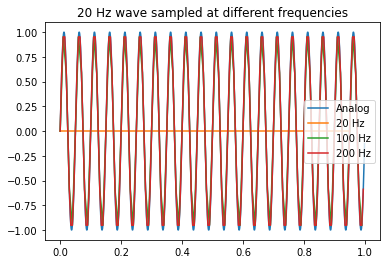

In [4]:
# plot with lines to emphasize differnces
plt.plot(time, analogSignal, label='Analog') # this should plot the number of sin waves defined by freq above
for i in digitalSignal:
    sig = digitalSignal[i]
    plt.plot(time[::sig['interval']], sig['data'], label=f'{i} Hz')
plt.title(f"{freq} Hz wave sampled at different frequencies")
plt.legend()

## Effects of aliasing 
From wikipedia
*In signal processing and related disciplines, aliasing is an effect that causes different signals to become indistinguishable (or aliases of one another) when sampled. It also often refers to the distortion or artifact that results when a signal reconstructed from samples is different from the original continuous signal.*

We'll look at using different sample rates that don't abide by the nuquist theorem.


Number of cycles: 100


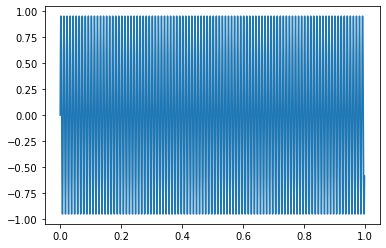

In [5]:
# here's a 100 hz waveform - we should have 100 cycles here
freq: float = 100.0
sampleRate: float = 1000.0
time = np.arange(0, 1.0, 1/sampleRate)
analogSignal = CreateSignal(1.0, freq, time)

# find # of peaks
numPeaks, _ = signal.find_peaks(analogSignal, height=0.0)
print(f"Number of cycles: {len(numPeaks)}")

# plot
plt.plot(time,analogSignal)

When we undersample this signal with sample rates of 80 and 90 Hz, we actually get 2 new waveforms that look nothing like the original. Sampling a 100 Hz waveform at 80 Hz creates a 20 Hz waveform and similarly, a sample rate of 90 Hz creates a 10 hz waveform. The aliased signal that is created from undersampling is actually the difference between the true signal frequency and the under-sample rate. 


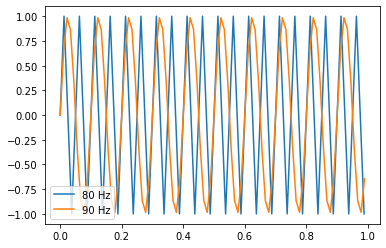

In [6]:

freq: float = 100.0
sampleRates: list = [80, 90]
fig = plt.figure()
for rate in sampleRates:
    time = np.arange(0, 1.0, 1/rate)
    analogSignal = CreateSignal(1.0, freq, time)
    plt.plot(time, analogSignal, label=f"{rate} Hz")
plt.legend()


### Key takeaways

* Don't undersample your data if you care about tempoeral features - in practice we want to be multiples of the nyquest freq so that we can appropriate capture the timing of peaks and peak magnitude. Nyquist theorem only ensures that the freq is preserved
* To prevent aliasing of higher frequencies in analog signals corrupting our digitized signals, we typically use an anti-aliasing filter set to the nyquist frequency in hardware (i.e. 2 x A/D sample rate)

## Bit resolution
In the analog to digital (A/D) conversion process, the bit resolution of the A/D converter defines the number of bins that exist for a given measurement range. This ultimately defines the smallest unit of measure that we're willing to digitize to. For example, a 12-bit A/D converter will have 4,096 bins. Depending on the input measurement range, the min resolution will change:

| Input Range (V) | Bin Resolution (V/bit) |
| :-------------: | :------------: |
| 0 - 5             | 0.001          |
| -5 - +5             | 0.002          |
|  0 - 1             | 0.0002          |

In reality, due to sampling noise, A/D converters typically cannot not achieve or use all their bits. You'll typically see specs for ENOB, or effective number of bits, that an A/D converter can achieve. One other technique that is incredibly powerful in increasing ENOB (even more than what an A/D is capable of), is to oversample the data. Oversamplng 4x achieves an increase in 1 bit (at a cost of time and power consumption).


Text(0.5, 1.0, '4.0 Hz waveform')

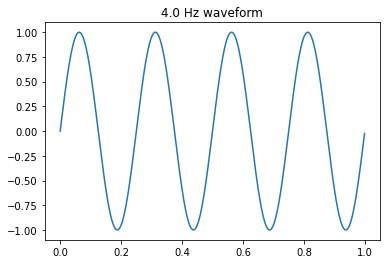

In [7]:
# here's a 4 hz waveform - we should have 100 cycles here
freq: float = 4.0
sampleRate: float = 1000.0
time = np.arange(0, 1.0, 1/sampleRate)
analogSignal = CreateSignal(1.0, freq, time)

plt.plot(time,analogSignal)
plt.title(f'{freq} Hz waveform')

In [ ]:
Lets take a look at the effects of A/D bit resolution to the signal above. 

[0.49996052 0.12499013]


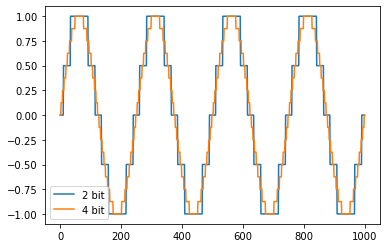

In [53]:
# various bit resolutions
bits: List = [2, 4]  # bit resolutions
voltageRange = np.max(analogSignal) - np.min(analogSignal) # volts
resolution = [2**bit for bit in bits]
volt2bit = voltageRange / resolution

# now lets digitize the signal
digitSig = np.zeros((len(analogSignal), len(bits)))
for i in range(len(bits)):
    digitSig[:, i] = np.round (analogSignal / volt2bit[i]) *  volt2bit[i]
    plt.plot(digitSig[:, i], label=f"{bits[i]} bit")

plt.legend()

The bit resolution directly determines the quantization of the signal amplitude. With a 2 bit signal over a 2 volt signal range, we basically have a 0.5 amplitude resolution or 4 discrete amplitude values. Depending on the application, this actually might be more than sufficient, but for others (e.g. when you need to calculate a derivative, this definitely won't be very meaninful). 

## Signal "gain" using A/D

To maximize the amplitude resolution, you want to modify your input measurement range to best match the signal of interest. For a +/- 1 Volt signal (i.e. 2 volt range peak-peak), a 4 bit resolution would result in 0.125 volts / bit. If we change this input rnage to be +/- 2 Volts or 4 volts range, the amplitude resolution would double from 0.125 volts to 0.25 volts


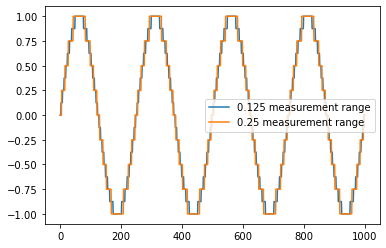

In [8]:
# various bit resolutions
bits: int = 4  
voltageRange: List = [2, 4]  # volts
resolution = 2**bits
volt2bit = [volt / resolution for volt in voltageRange]

# now lets digitize the signal
digitSig = np.zeros((len(analogSignal), len(volt2bit)))
for i in range(len(volt2bit)):
    digitSig[:, i] = np.round (analogSignal / volt2bit[i]) *  volt2bit[i]
    plt.plot(digitSig[:, i], label=f"{volt2bit[i]} measurement range")

plt.legend()

## Takeaways
* Why wouldn't I always use max bit resolution?
    * Data size - <= 8 bit resolution only requires 1 data byte; <= 16 bits doubles the data - For a given application, how much resolution is required to be meaningful?
    * Power consumption - at a hardware level, higher resolution generally requires longer data acquisition times consuming more power
* Be careful when selecting A/D Data acqusition systems - a 16 bit resolution A/D system simply means that it has the capacity to measure 16 bits, but the real # of bits (i.e. effective # of bits) will likely be less by a few bits. Each additional bit halves the resolution (i.e. 2^3 has 8 resolutions vs 2^4 has 16 resolutions). See note above

# Time series filtering


## Bode Plots



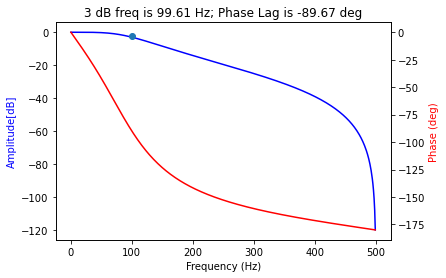

In [9]:
# create an IIR butterworth filter with cutoff frequency Fc of 100
order: int = 2
sampleRate: float = 1000  # Hz
Fc: float = 100  # Hz
b, a = signal.butter(2, Fc/(sampleRate/2))  # get filter coefficients. Fc is a ratio of nyquist freq

# create a bode plot
w, h = signal.freqz(b, a, fs=sampleRate)
freqMag = 20 * np.log10(abs(h))
phase = np.unwrap(np.angle(h)) * 57.3

fig, ax1 = plt.subplots()
ax1.plot(w, freqMag, 'b')
ax1.set_ylabel('Amplitude[dB]', color='b')
ax2 = ax1.twinx()
ax2.plot(w, phase, 'r')
ax2.set_ylabel('Phase (deg)', color='r')
ax1.set_xlabel('Frequency (Hz)')

# show 3 dB point
minDiff = abs(abs(freqMag) - 3)
dbIdx = np.argmin(minDiff) 
# dbIdx = np.where((freqMag > -2) & (freqMag < -4))[0]
w[dbIdx]
plt.plot(w[dbIdx], freqMag[dbIdx], marker='o')
plt.title(f"3 dB freq is {w[dbIdx]:2.2f} Hz; Phase Lag is {phase[dbIdx]:2.2f} deg")
phase90 = phase[dbIdx]



The plot above is bode plot showing the phase and amplitude response for a 2nd order butterworth filter with a Fc of 100 Hz. The 3 dB point is at 99.61 Hz (closest value to 100Hz). Notice that at the cutoff frequency, the phase lag is still -90 deg. Also, when we zoom in, even within the flat response region of the filter, there is still a phase lag that is induced in the filtered response

Text(0.5, 1.0, 'in passband, the Phase Lag is still -17.90 deg and increases linearly')

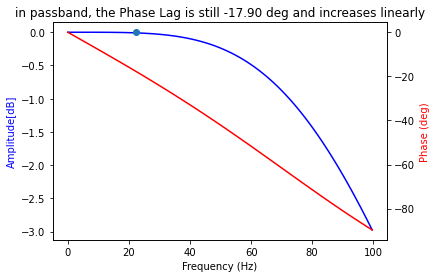

In [10]:
idx = np.where(w <= 100)
fig, ax1 = plt.subplots()
ax1.plot(w[idx], freqMag[idx], 'b')
ax1.set_ylabel('Amplitude[dB]', color='b')
ax2 = ax1.twinx()
ax2.plot(w[idx], phase[idx], 'r')
ax2.set_ylabel('Phase (deg)', color='r')
ax1.set_xlabel('Frequency (Hz)')

# show 3 dB point
minDiff = abs(abs(freqMag) - .01)
dbIdx = np.argmin(minDiff) 
# dbIdx = np.where((freqMag > -2) & (freqMag < -4))[0]
w[dbIdx]
plt.plot(w[dbIdx], freqMag[dbIdx], marker='o')
plt.title(f"in passband, the Phase Lag is still {phase[dbIdx]:2.2f} deg and increases linearly")

## The 3 dB point 
Frequency cutoffs are typically specified at the 3 dB roll off point from a frequency response curve. At this point, the power of the signal is cut in half (or V^2) and the magnitude has been reduced to 1/sqrt(2) or 0.7071 or cos(45 deg) (20 * log10(1/sqrt(2)) and the phase lag for a second order filter is approx 90 deg. A cheap analog circuit that calculates a derivative of a signal can be made by simply passing signal above a simple RC filter!

Text(0.5, 1.0, 'a phase lag of -89.7 looks like a cos or a derivative of -sin')

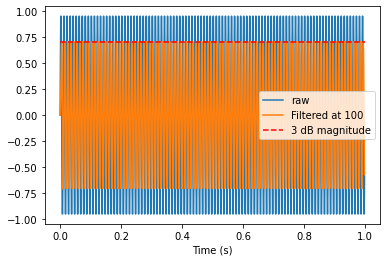

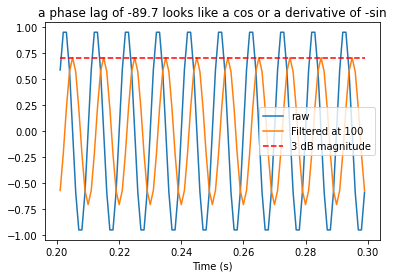

In [11]:
# create an "analog" signal
amp: float = 1.0  # signal amplitude in A.U.
freq: float = 100  # signal frequency in Hz
sampleRate: float = 1000.0  # really high sample rate in Hz
time: np.ndarray = np.arange(0, 1.0, 1.0/sampleRate)  # create a time series with really small delta t in secs
analogSignal = CreateSignal(amp, freq, time)

# filter this signal using the filter above
filtSignal = signal.lfilter(b, a, analogSignal)

# plot results
plt.figure()
plt.plot(time, analogSignal, label='raw')
plt.plot(time, filtSignal, label=f"Filtered at {Fc}")
plt.xlabel('Time (s)')

# add horizontal line for 3dB threshold
baseline = (1/np.sqrt(2)) * np.ones(len(time), np.float32)
plt.plot(time, baseline, 'r--', label='3 dB magnitude')
plt.legend()

# zooming in shows you the phase lag
idx = np.where((time > 0.2) & (time < 0.3))
plt.figure()
plt.plot(time[idx], analogSignal[idx], label='raw')
plt.plot(time[idx], filtSignal[idx], label=f"Filtered at {Fc}")
plt.xlabel('Time (s)')

# add horizontal line for 3dB threshold
plt.plot(time[idx], baseline[idx], 'r--', label='3 dB magnitude')
plt.legend()
plt.title(f"a phase lag of {phase90:2.1f} looks like a cos or a derivative of -sin")
